In [1]:
%pylab inline
from JSAnimation import IPython_display
from matplotlib import animation
from __future__ import print_function
import time
from channels import *
from compartment import *
from membrane import *
from params import *
from glutamate import *

from csdmodel1d import *

import numpy as np
np.seterr(all='ignore')
from scipy.integrate import ode

Populating the interactive namespace from numpy and matplotlib


In [2]:
model = CSDModelInterval(N=11,dx=50e-6) # define the model, grid spacing is 100 microns, or approximately two cell widths

# Define the compartments, and the membranes
ecs = Compartment("ecs")
neuron = CellCompartment("neuron",density = 2e5) # 2e5 neurons per meter, 4e10 per sq meter
glia = CellCompartment("glia",density = 2e5) #2e5 glia per meter

neuronal_er = CellCompartment("neuron_er",density = 2e5)
glial_er = CellCompartment("glia_er",density = 2e5)

neuronal_mito = CellCompartment("neuron_mito",density = 2e5)
glial_mito = CellCompartment("glial_mito",density = 2e5)

neuron_mem = Membrane("neuronal",inside=neuron,outside=ecs,Cm=Cn,phi_m=-70e-3)
glial_mem = Membrane("glial",inside=glia,outside=ecs,Cm=Cg,phi_m=-85e-3)

neuronal_er_mem = Membrane("neuronal_er",inside=neuronal_er,outside=neuron,Cm=Cn,phi_m=0.0)
neuronal_er_mem = Membrane("glial_er",inside=glial_er,outside=glia,Cm=Cn,phi_m=0.0)


# Add the compartments to the model
model.addCompartment(ecs,fraction=0.2) # ECS take 20% of the total volume
model.addCompartment(neuron,fraction=0.4-0.04) # Neurons take up 40% of the total volume
model.addCompartment(glia,fraction=0.4-0.04) # Neurons take up 40% of the total volume
model.addCompartment(neuronal_er,fraction = 0.02)
model.addCompartment(glial_er,fraction = 0.02)
model.addCompartment(neuronal_mito,fraction = 0.02)
model.addCompartment(glial_mito,fraction = 0.02)

# Add ion species
ecs.addSpecies(K,Ke0,name='K_e')
ecs.addSpecies(Cl,Cle0,name='Cl_e')
ecs.addSpecies(Na,Nae0,name='Na_e')
ecs.addSpecies(Ca,Cae0,name='Ca_e')
ecs.addSpecies(Glu,ge0,name = "g_e") # 4 micromolar in ecs

neuron.addSpecies(K,Ki0,0,'K_n')
neuron.addSpecies(Na,Nai0,0,'Na_n')
neuron.addSpecies(Cl,Cli0,0,'Cl_n')
neuron.addSpecies(Ca,Cai0,0,'Ca_n')
neuron.addSpecies(Glu,1e-6,name = "g_n")

glia.addSpecies(K,Kg0,name='K_g')
glia.addSpecies(Na,Nag0,name='Na_g')
glia.addSpecies(Cl,Clg0,name='Cl_g')
glia.addSpecies(Ca,Cag0,0,'Ca_g')

# add channels
neuron_mem.addChannel(NaTChannel(quasi_steady=True),10000.) # 10000 per neuron?
neuron_mem.addChannel(NaPChannel(quasi_steady=True),100.) # 100 per neuron
neuron_mem.addChannel(KDRChannel(),10000.) # number of channels per neuron
neuron_mem.addChannel(KAChannel(quasi_steady=True),10000.) # number of channels per neuron
neuron_mem.addChannel(SKChannel(),1000.) # SK
neuron_mem.addChannel(CaPChannel(),10000.) # number of channels per neuron
neuron_mem.addChannel(CaLChannel(),10000.) # number of channels per neuron
neuron_mem.addChannel(CaNChannel(quasi_steady=True),10000.) # number of channels per neuron
neuron_mem.addChannel(gNMDAChannel(),10000.)

neuron_mem.addChannel(PMCAPump(),10000) # PMCA pump
neuron_mem.addChannel(NaCaExchangePump(),1000) # sodium-calcium exchanger
neuron_mem.addChannel(NaKATPasePump(),4e4) # 5000 ATPase per neuron
neuron_mem.addChannel(NonSpecificChlorideChannel(phi0),1e7)
neuron_mem.addChannel(AquaPorin(),1e-7) # Add water exchange

glial_mem.addChannel(KIRChannel(),50000) # KIR Channel
glial_mem.addChannel(NaKATPasePump(),4e4) # 10000000 ATPase per glia
glial_mem.addChannel(KDRglialChannel(),175000)
glial_mem.addChannel(PMCAPump(),10000)
glial_mem.addChannel(NaCaExchangePump(),1000) # sodium-calcium exchanger
glial_mem.addChannel(NonSpecificChlorideChannel(phig0),1e7)
glial_mem.addChannel(AquaPorin(),1e-7) # Add water exchange

glial_mem.addChannel(CaPChannel(),10000.) # number of channels per neuron
glial_mem.addChannel(CaLChannel(),10000.) # number of channels per neuron
#glial_mem.addChannel(CaNChannel(),10000.) # number of channels per neuron

# add glutamate exocytosis
#glutamate_exo = GlutmateExocytosis("G_exo", 1000)
#neuron_mem.addReaction(glutamate_exo)



In [3]:
model.addMembrane(neuron_mem)
model.addMembrane(glial_mem)

#model.addReaction(glutamate_exo)

neuron_mem.addLeakChannels()
neuron.balanceWith(ecs)
glial_mem.addLeakChannels()
glia.balanceWith(ecs)

model.assembleSystem()

system_state = model.getInternalVars()

Ion: Na+, P_leak: 5.48E-10
Ion: K+, P_leak: 7.61E-09
Ion: Ca2+, P_leak: 4.90E-11
Ion: Na+, P_leak: 2.05E-09
Ion: K+, P_leak: 9.17E-08
Ion: Ca2+, P_leak: 6.97E-11


#Hole method for initiation - very slow!!
neuron_hole = HoleChannel([K,Na,Cl],1.0)
density = np.zeros(model.N)
density[0] = 1
neuron_mem.addChannel(neuron_hole,density)

#glial_hole = HoleChannel([K,Na,Cl],1e-2)
#glial_mem.addChannel(glial_hole,density)

In [4]:
#Let's just turn off the pumps

neuron_pump_index = np.where([type(channel) is NaKATPasePump for channel in neuron_mem.channels])
neuron_mem.channeldensity[neuron_mem.channels[neuron_pump_index[0]]]*=np.ones(model.N)
neuron_mem.channeldensity[neuron_mem.channels[neuron_pump_index[0]]][0]*=0.00

glial_pump_index = np.where([type(channel) is NaKATPasePump for channel in glial_mem.channels])
glial_mem.channeldensity[glial_mem.channels[glial_pump_index[0]]]*=np.ones(model.N)
glial_mem.channeldensity[glial_mem.channels[glial_pump_index[0]]][0]*=0.00

In [5]:
y = model.getInternalVars()
model.odesolver.set_initial_value(y,0)

stim_duration = 10.0 # poke holes for 1 seconds
t_old = -stim_duration
model.odesolver.t = -stim_duration
dt1 = -stim_duration # timescale separation
t_old1 = -stim_duration
system_states = []
t = []
meanflux = 0.0
t.append(-stim_duration)
start_time = time.time()

In [6]:
print('{:<7} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10} {:<10}'.format('time', 'V_n','V_g', 'K_e', 'K_n','K_g','Cl_e','Ca_n','g_e') )
print('{:<7.3f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:10.6f} {:10.6f}'.format(model.odesolver.t, 1e3*neuron_mem.phi()[0], 1e3*glial_mem.phi()[0], 1e3*ecs.value(K)[0], 1e3*neuron.value(K)[0], 1e3*glia.value(K)[0], 1e3*ecs.value(Cl)[0], 1e3*neuron.value(Ca)[0], 1e3*ecs.value(Glu)[0]), end='\r')

try:
    y = model.odesolver.integrate(model.odesolver.t+1e-6)
    system_states.append(y)
    t.append(model.odesolver.t)
    while model.odesolver.successful() and model.odesolver.t < 0.0:
        y = model.odesolver.integrate(model.odesolver.t+1e-3)
        if sum(isnan(y))>0: break
        print('{:<7.3f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:10.6f}'.format(model.odesolver.t, 1e3*neuron_mem.phi(y)[0], 1e3*glial_mem.phi(y)[0], 1e3*ecs.value(K,y)[0], 1e3*neuron.value(K,y)[0], 1e3*glia.value(K,y)[0], 1e3*ecs.value(Cl,y)[0], 1e3*neuron.value(Ca,y)[0], 1e3*ecs.value(Glu,y)[0]), end='\r')
        system_states.append(y)
        t.append(model.odesolver.t)
        
    #neuron_mem.removeChannel(neuron_hole)
    #glial_mem.removeChannel(glial_hole)
    #model.odesolver.set_initial_value(y)
    
    while model.odesolver.successful() and model.odesolver.t < 120.0:  
        y = model.odesolver.integrate(model.odesolver.t+1e-3)
        if sum(isnan(y))>0: break
        print('{:<7.3f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:10.6f}'.format(model.odesolver.t, 1e3*neuron_mem.phi(y)[0], 1e3*glial_mem.phi(y)[0], 1e3*ecs.value(K,y)[0], 1e3*neuron.value(K,y)[0], 1e3*glia.value(K,y)[0], 1e3*ecs.value(Cl,y)[0], 1e3*neuron.value(Ca,y)[0], 1e3*ecs.value(Glu,y)[0]), end='\r')
        system_states.append(y)
        t.append(model.odesolver.t)    
except KeyboardInterrupt:
    print('{:<7.3f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:10.6f}'.format(model.odesolver.t, 1e3*neuron_mem.phi(y)[0], 1e3*glial_mem.phi(y)[0], 1e3*ecs.value(K,y)[0], 1e3*neuron.value(K,y)[0], 1e3*glia.value(K,y)[0], 1e3*ecs.value(Cl,y)[0], 1e3*neuron.value(Ca,y)[0], 1e3*ecs.value(Glu,y)[0]))
   
print('{:<7.3f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:10.6f}'.format(model.odesolver.t, 1e3*neuron_mem.phi(y)[0], 1e3*glial_mem.phi(y)[0], 1e3*ecs.value(K,y)[0], 1e3*neuron.value(K,y)[0], 1e3*glia.value(K,y)[0], 1e3*ecs.value(Cl,y)[0],1e3*neuron.value(Ca,y)[0], 1e3*ecs.value(Glu,y)[0]), end='\r')
elapsed_time = time.time() - start_time
print('{:<7.3f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:<10.6f} {:10.6f}'.format(model.odesolver.t, 1e3*neuron_mem.phi(y)[0], 1e3*glial_mem.phi(y)[0], 1e3*ecs.value(K,y)[0], 1e3*neuron.value(K,y)[0], 1e3*glia.value(K,y)[0], 1e3*ecs.value(Cl,y)[0], 1e3*neuron.value(Ca,y)[0], 1e3*ecs.value(Glu,y)[0]))
print("\nElapsed time %.3f" % (elapsed_time) )

time    V_n        V_g        K_e        K_n        K_g        Cl_e       Ca_n       g_e       
7.113   -67.910522 -81.984987 4.592272   132.280234 113.123877 143.964943 0.000055     0.004000
7.113   -67.910522 -81.984987 4.592272   132.280234 113.123877 143.964943 0.000055     0.004000

Elapsed time 363.820



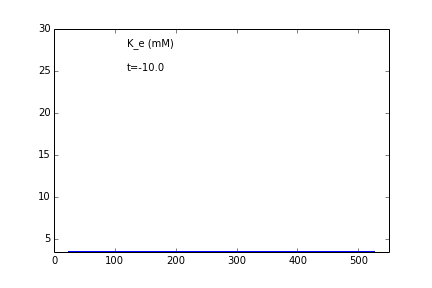
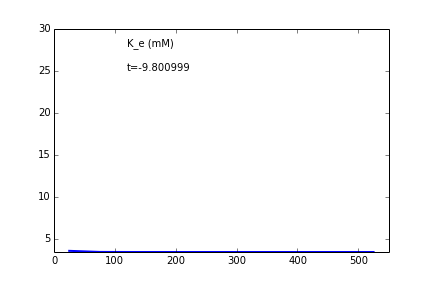
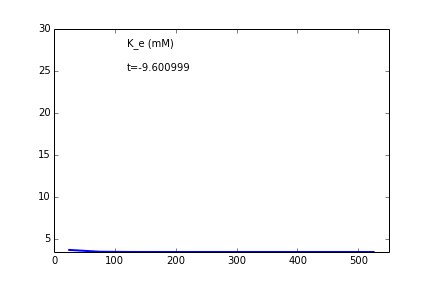
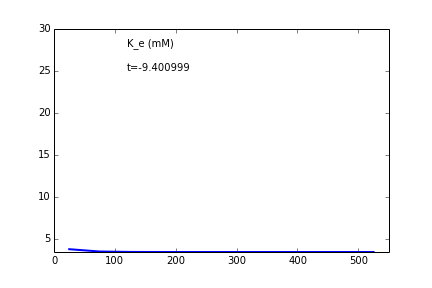
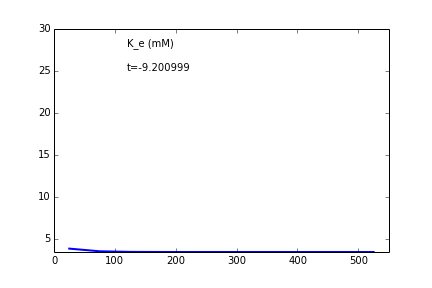
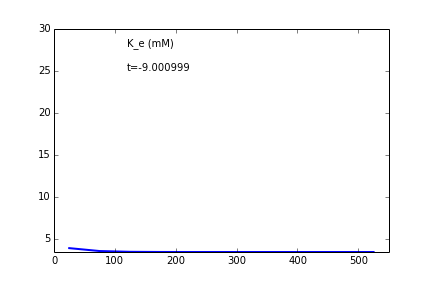
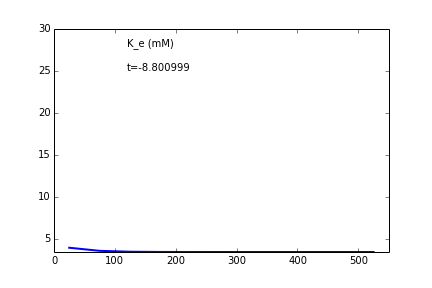
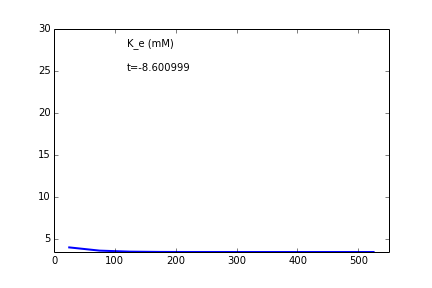
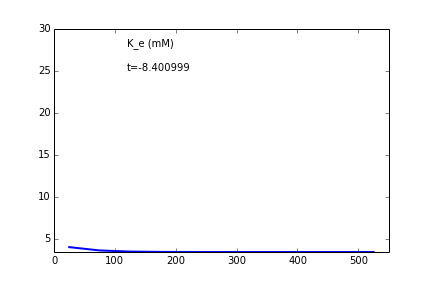
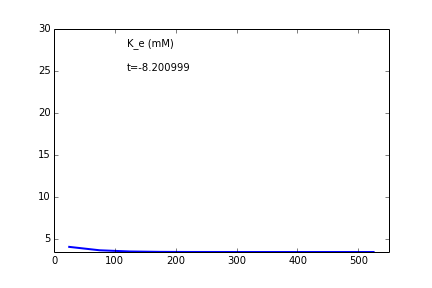
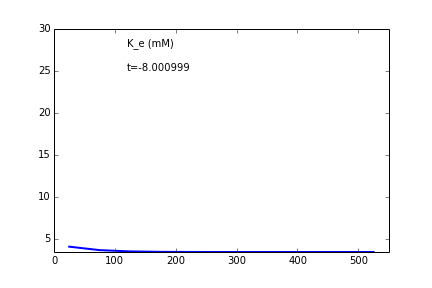
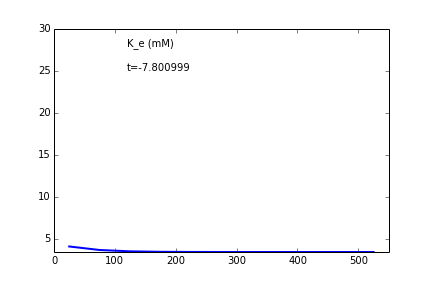
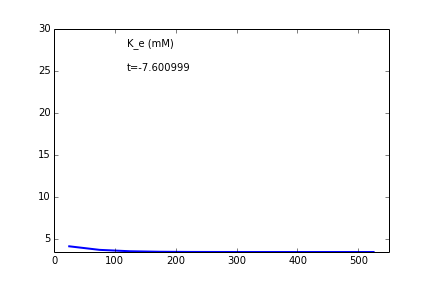
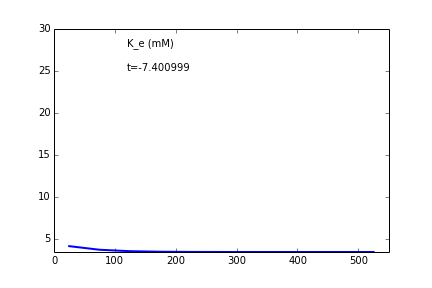
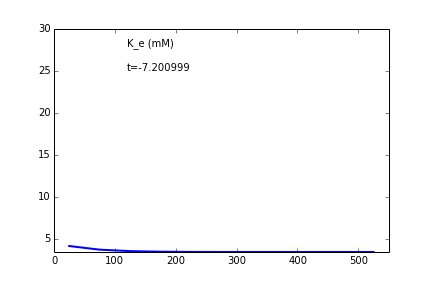
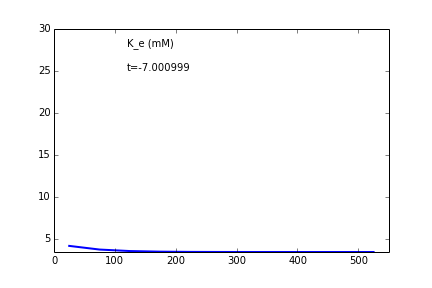
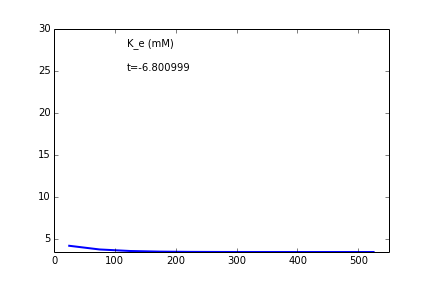
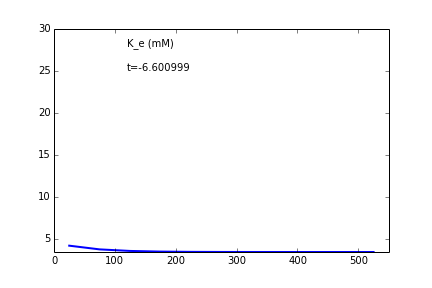
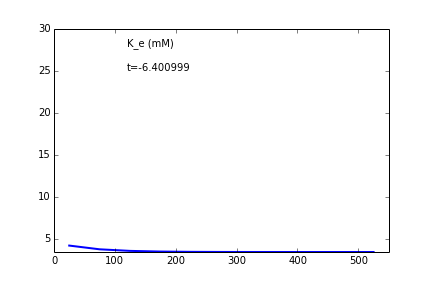
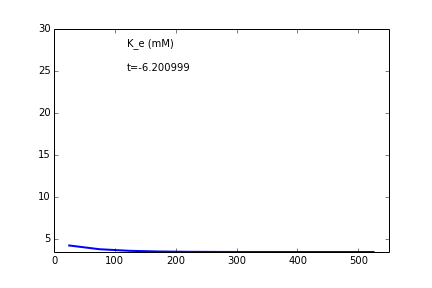
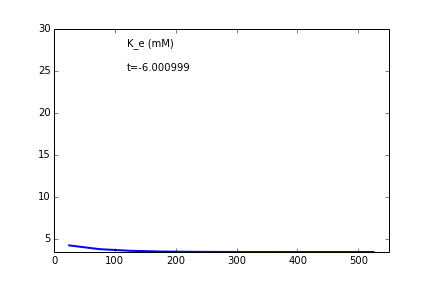
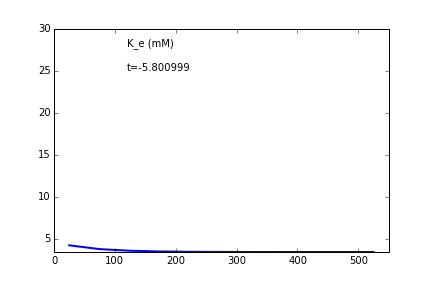
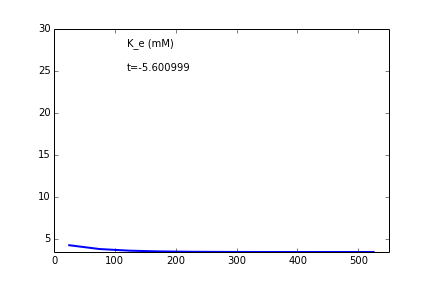
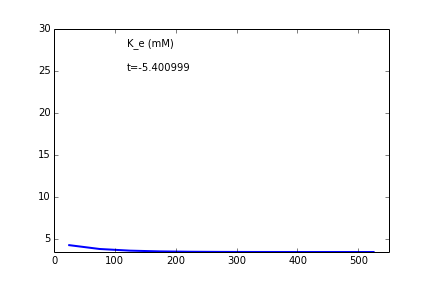
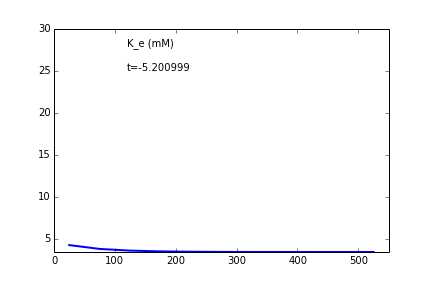
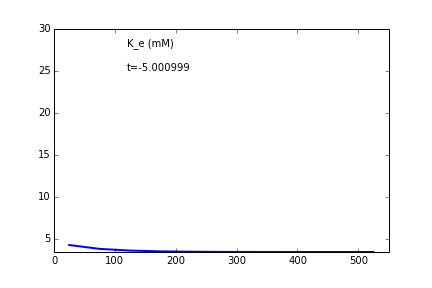
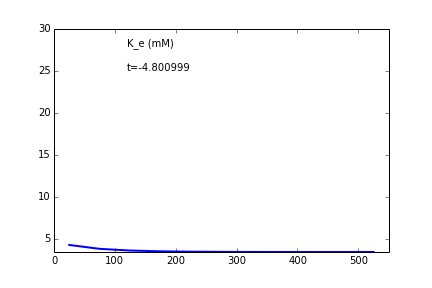
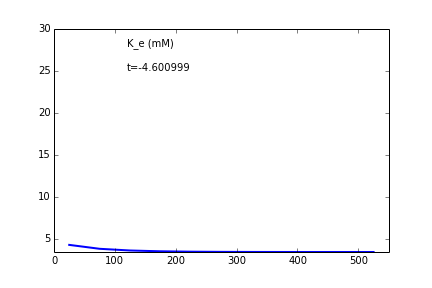
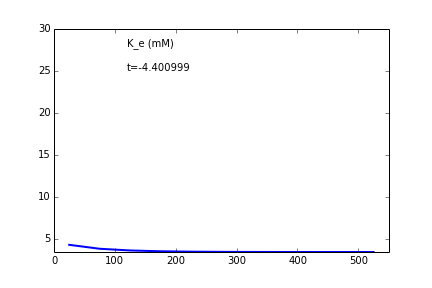
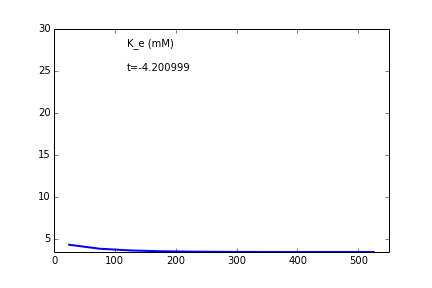
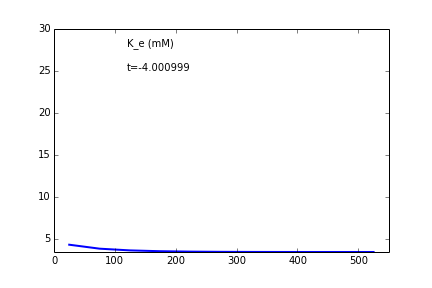
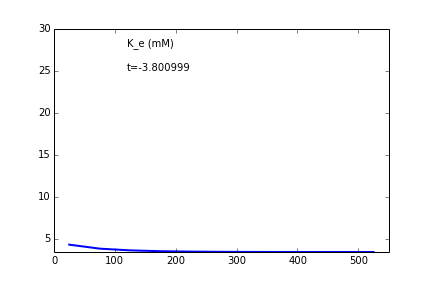
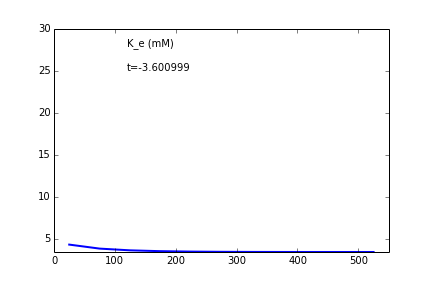
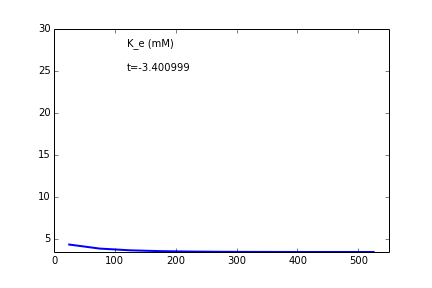
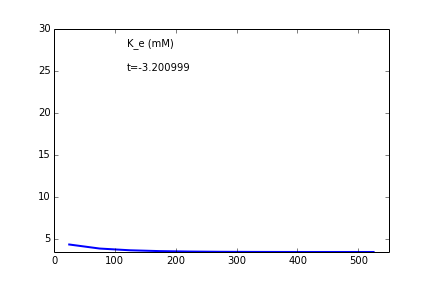
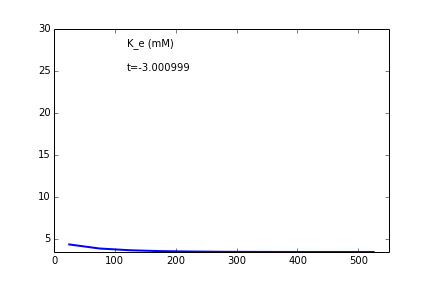
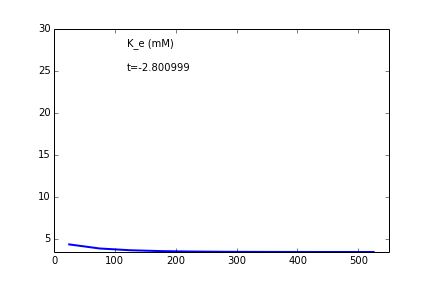
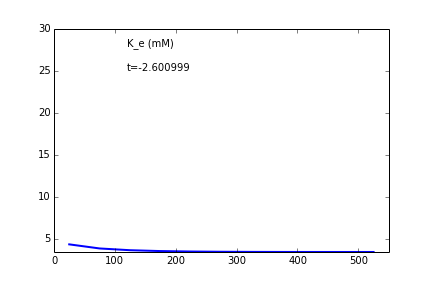
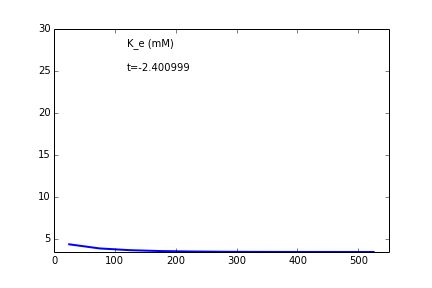
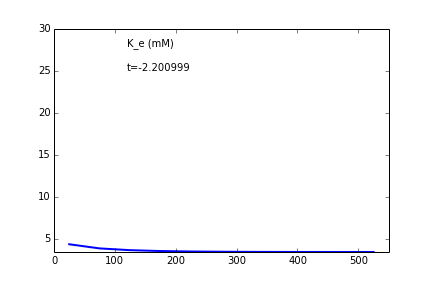
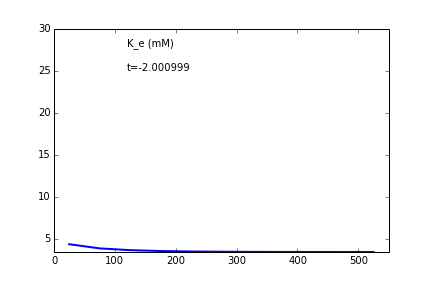
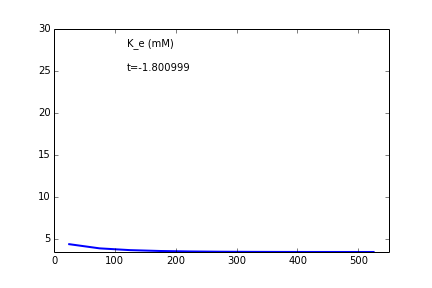
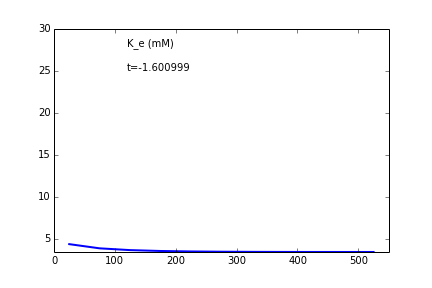
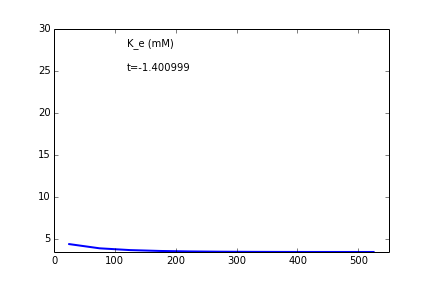
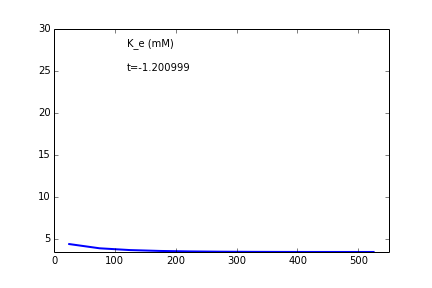
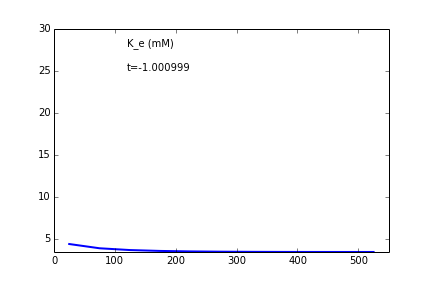
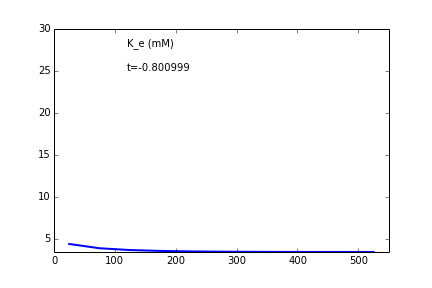
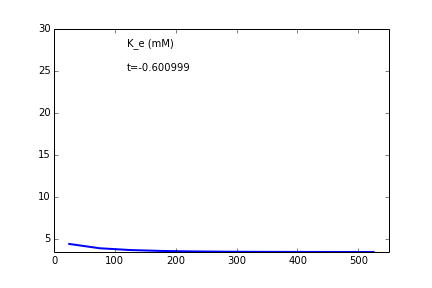
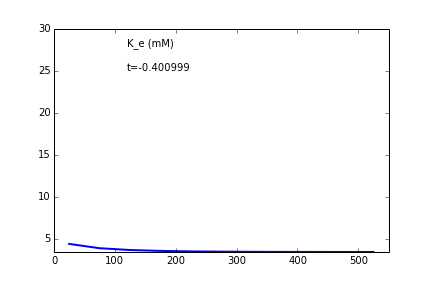
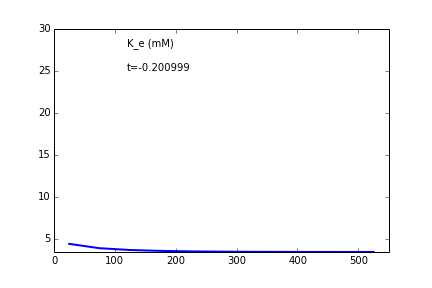
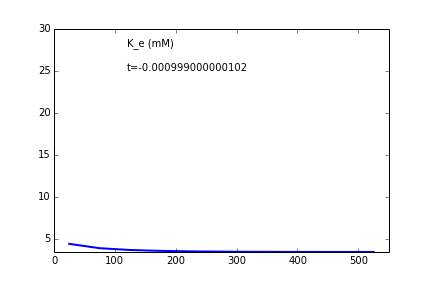
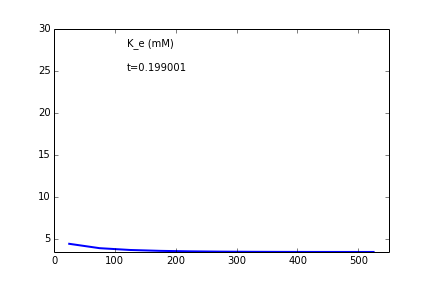
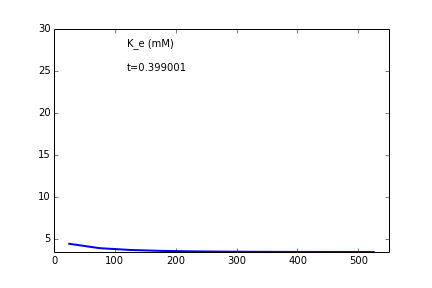
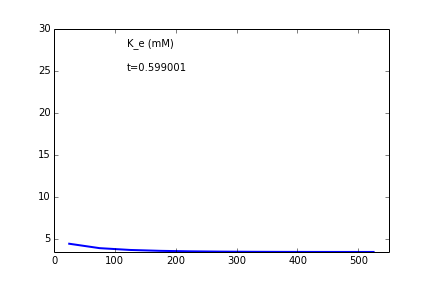
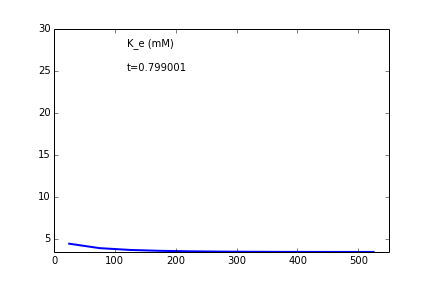
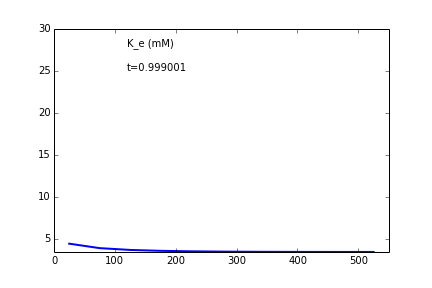
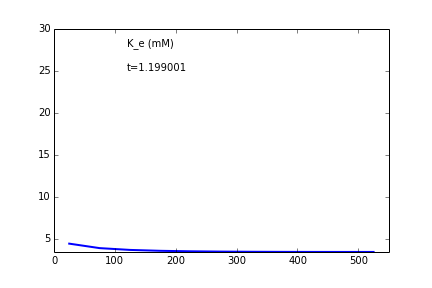
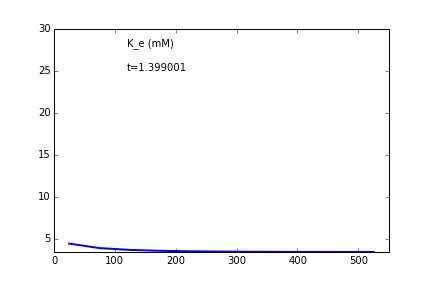
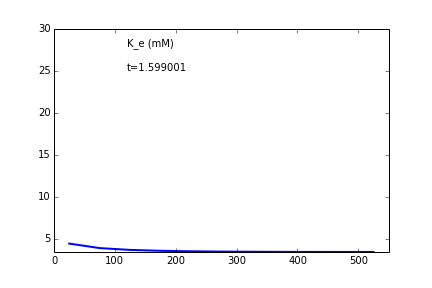
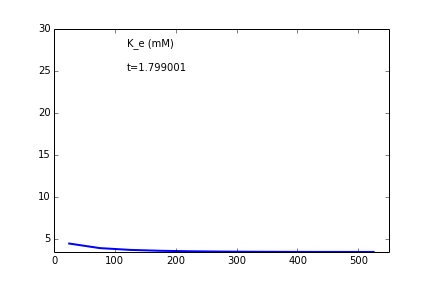
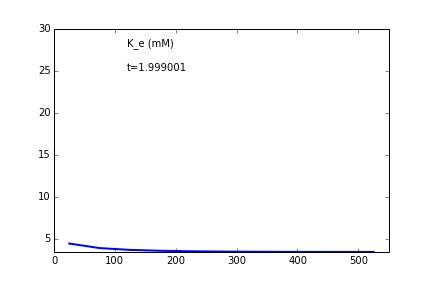
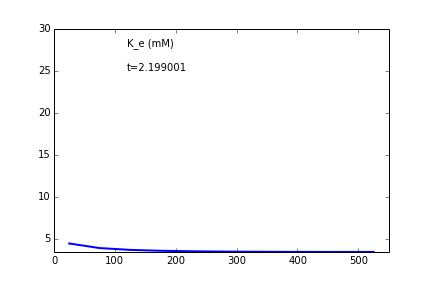
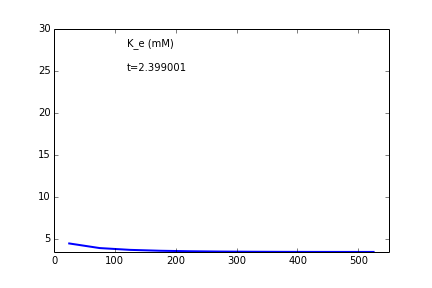
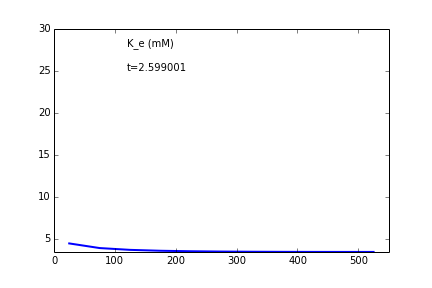
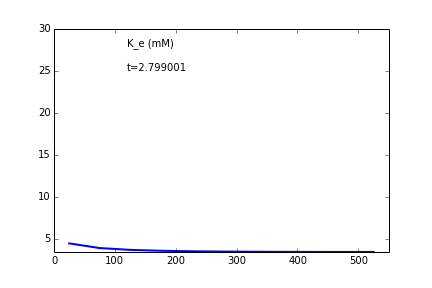
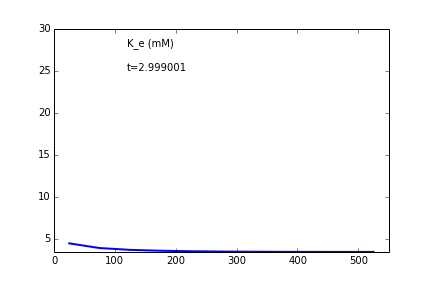
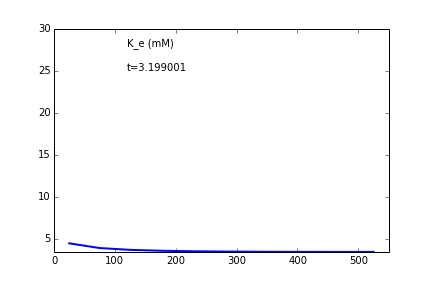
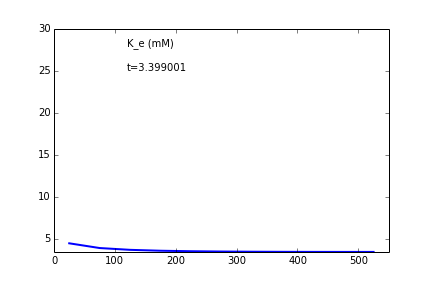
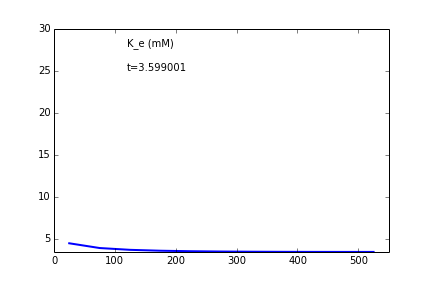
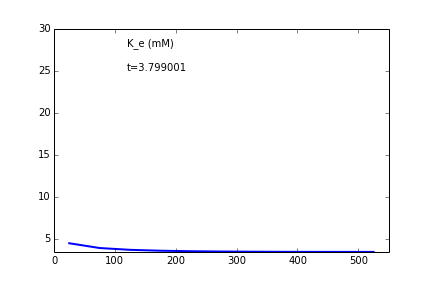
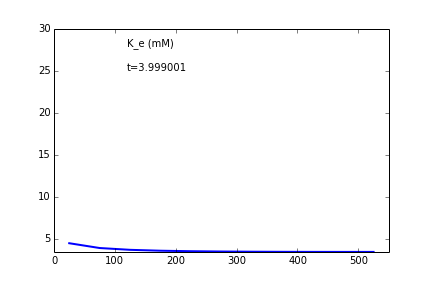
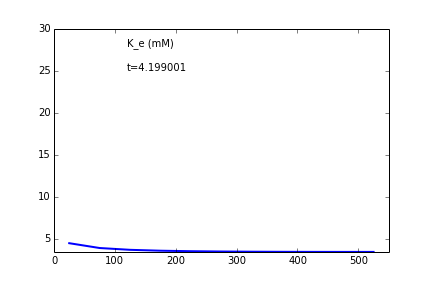
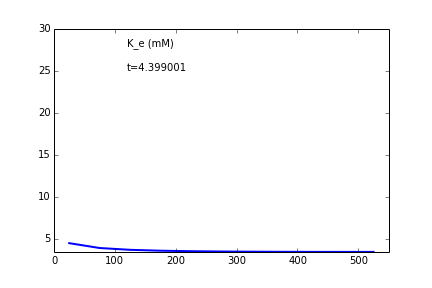
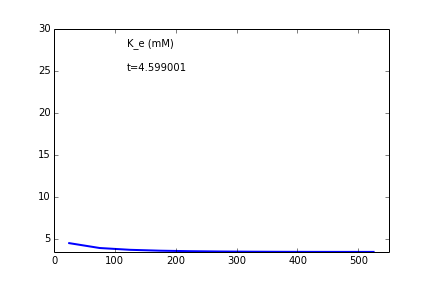
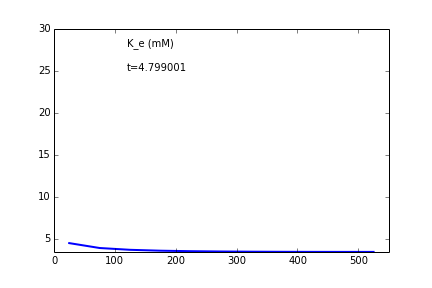
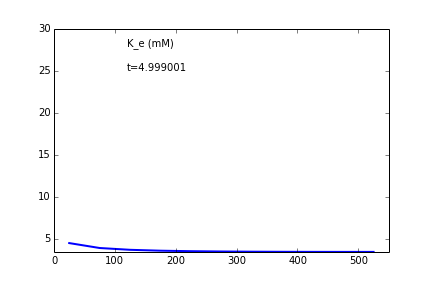
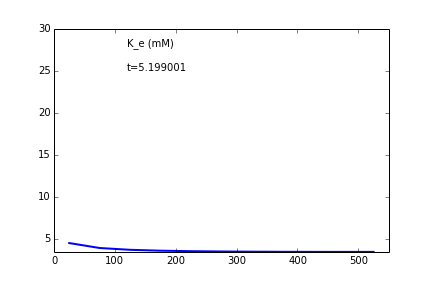
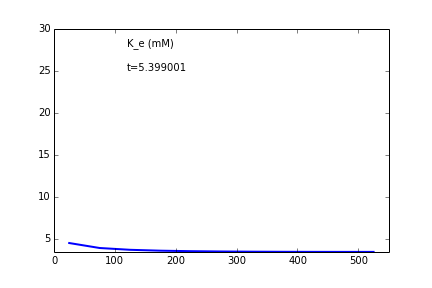
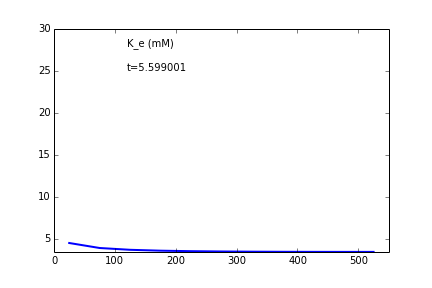
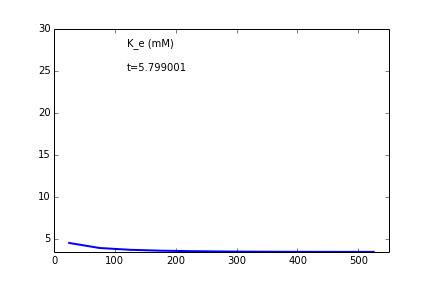
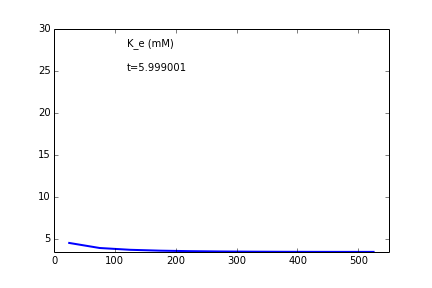
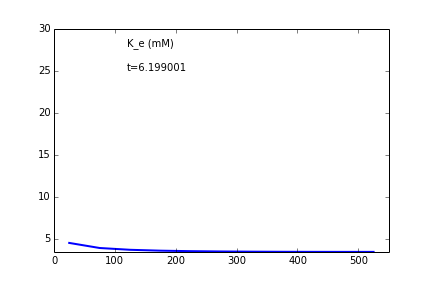
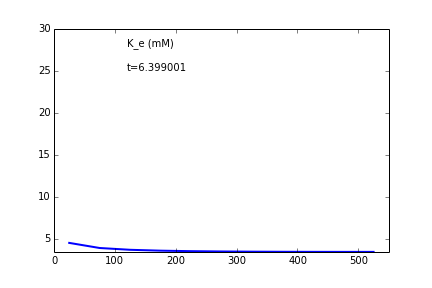
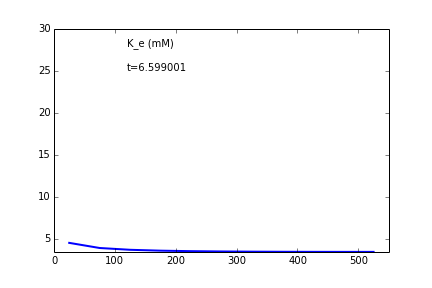
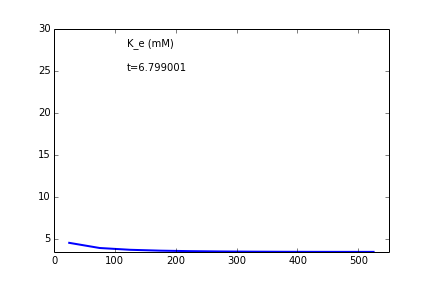

In [7]:
fig = plt.figure()
ax = plt.axes(xlim=(0, model.N*model.dx*1e6), ylim=(3.5, 30))
line, = ax.plot([], [], lw=2)
tt0 = ax.text(120, 28, 'K_e (mM)')
ttl = ax.text(120, 25, '')

dt = 200
frames = len(system_states)/dt

def init():
    line.set_data([], [])
    ttl.set_text('t='+str(0.0))
    return line,

def animate(i):
    line.set_data(model.x*1e6,ecs.value(K,system_states[i*dt])*1e3)
    ttl.set_text('t='+str(t[i*dt]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=frames, interval=100, blit=True)


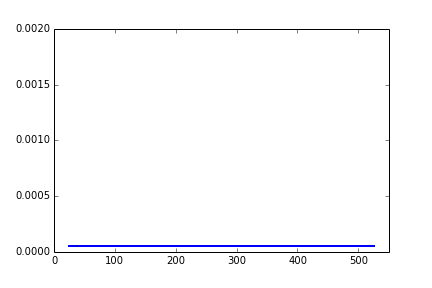
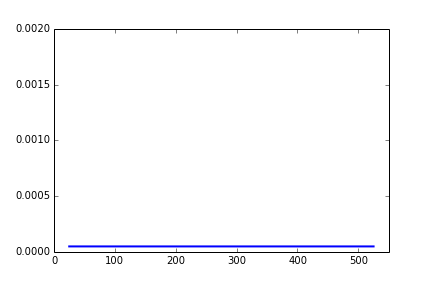
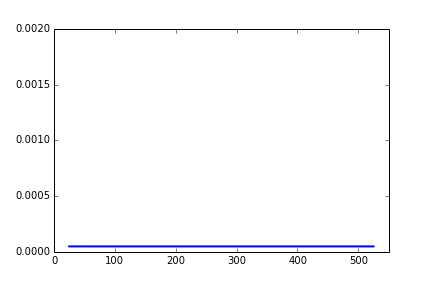
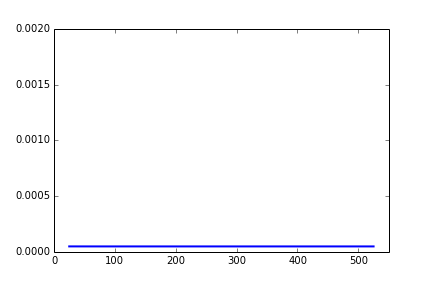
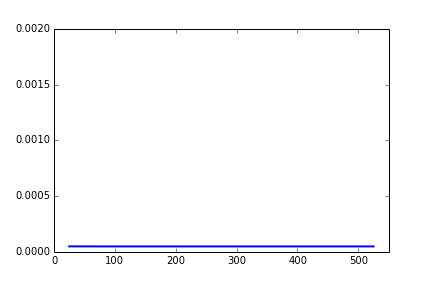
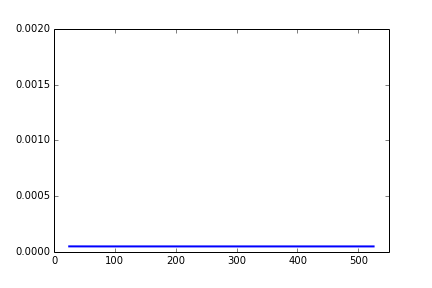
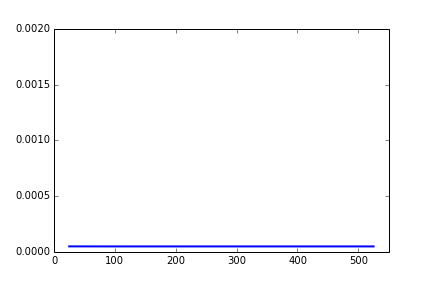
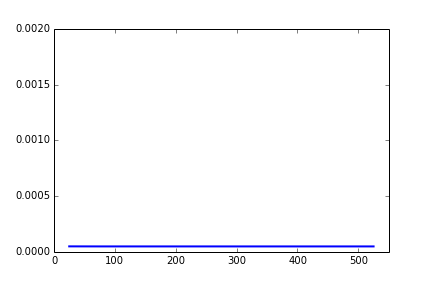
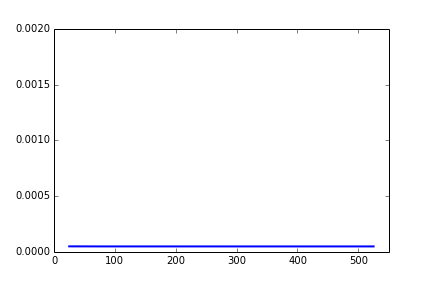
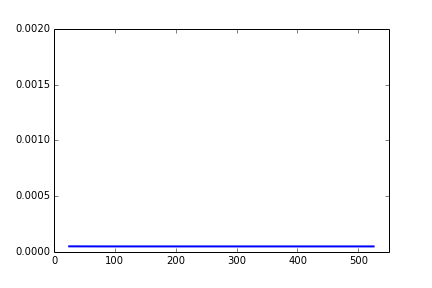
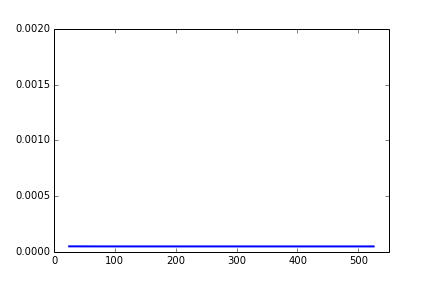
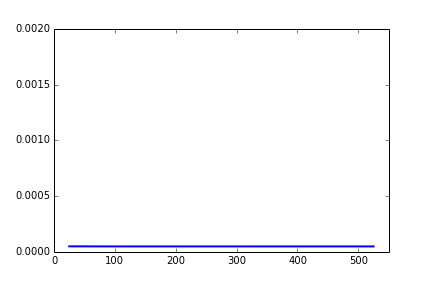
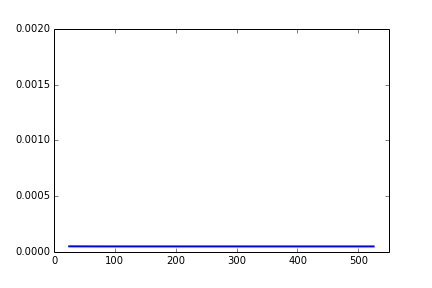
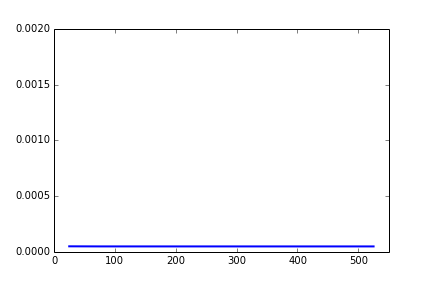
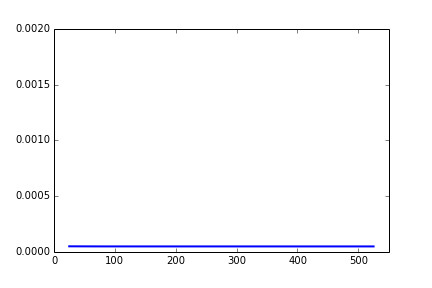
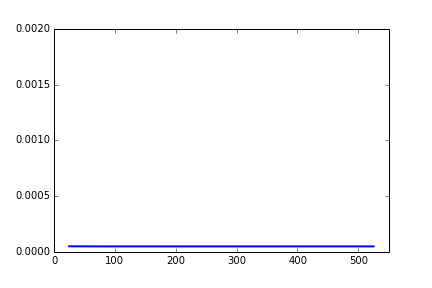
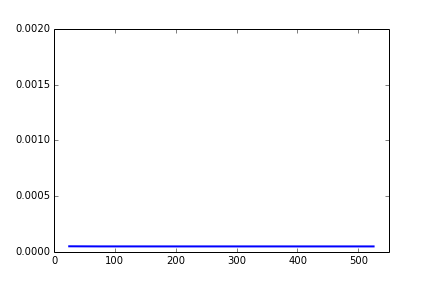
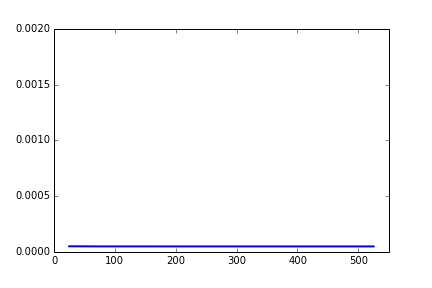
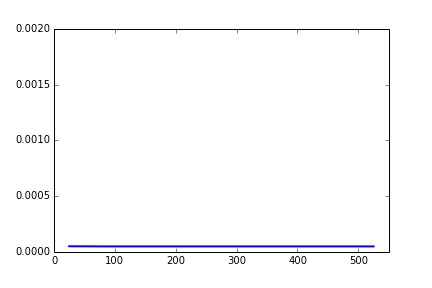
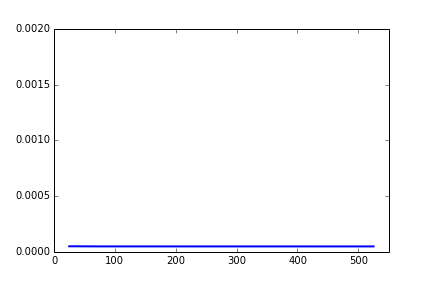
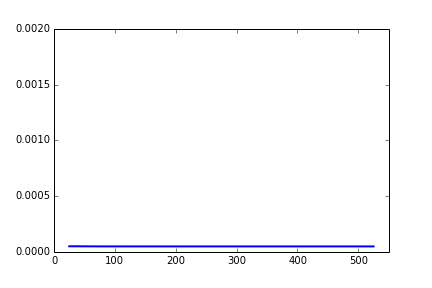
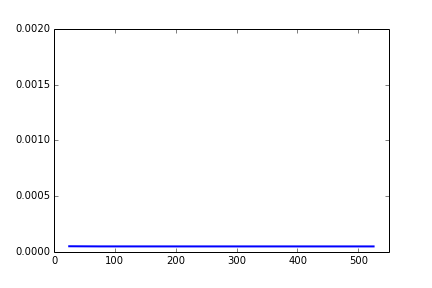
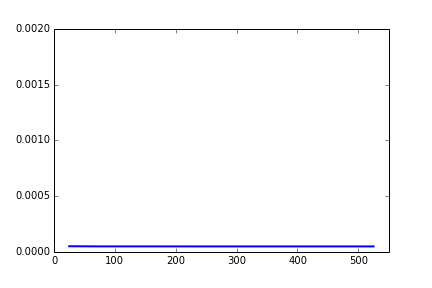
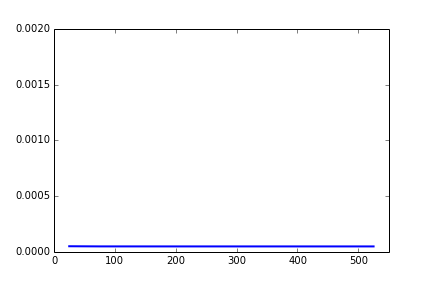
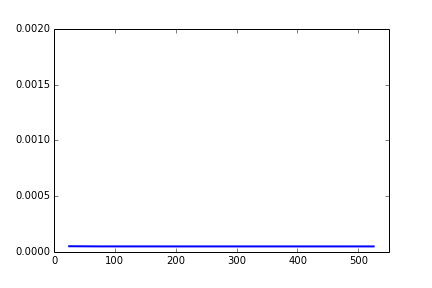
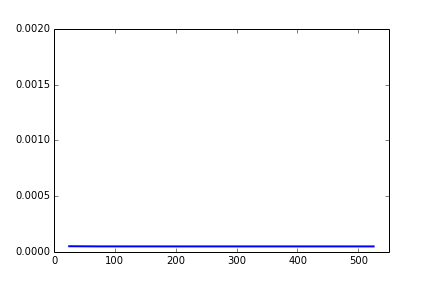
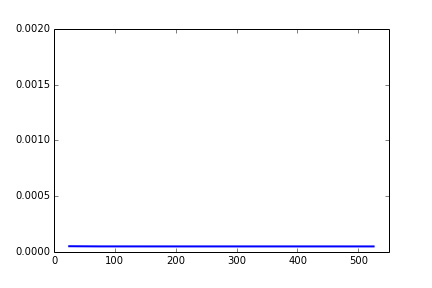
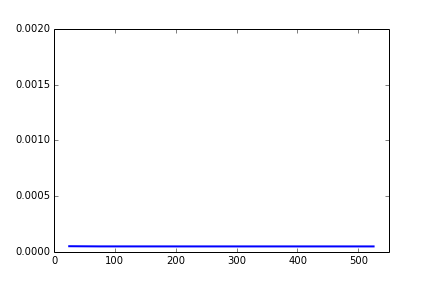
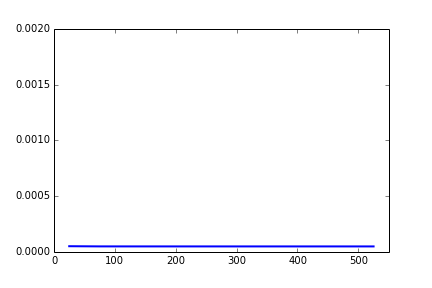
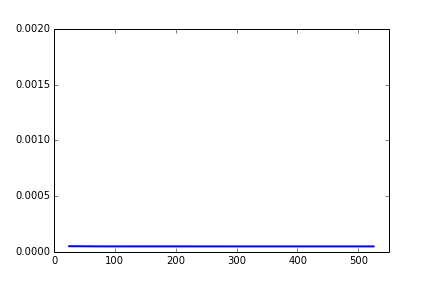
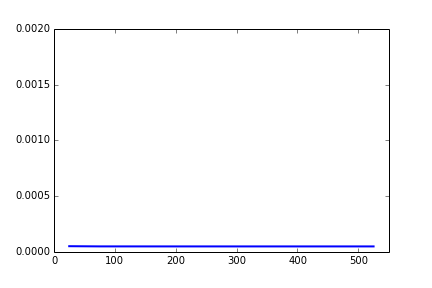
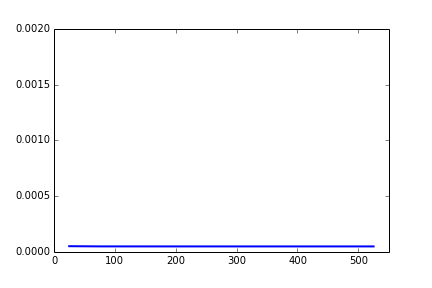
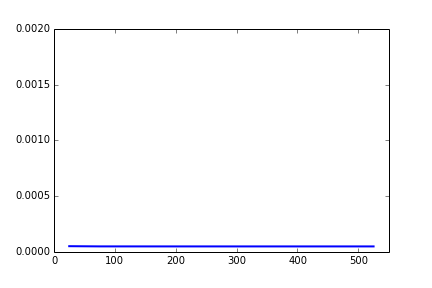
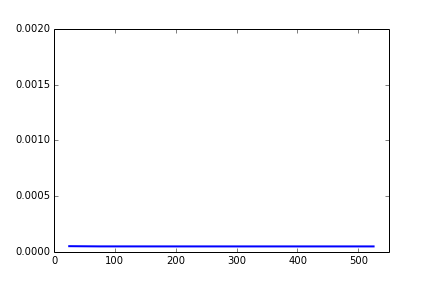
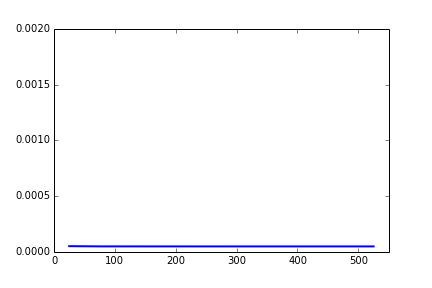
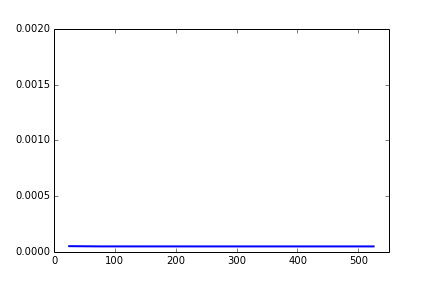
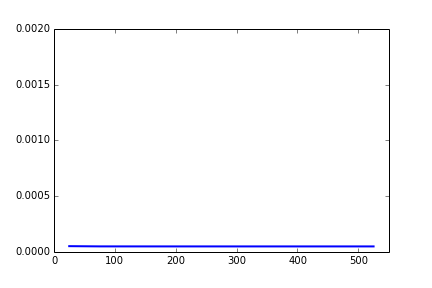
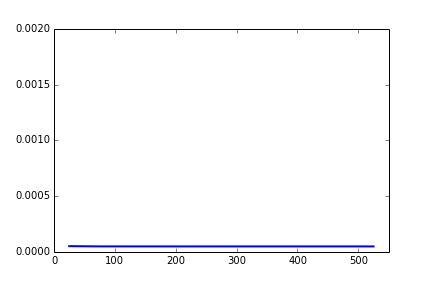
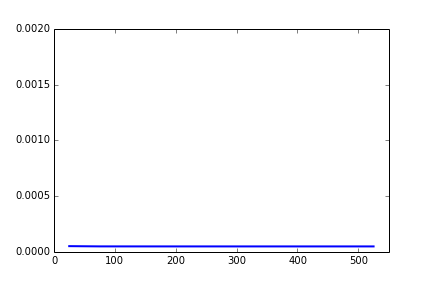
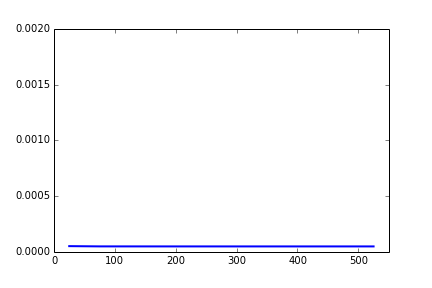
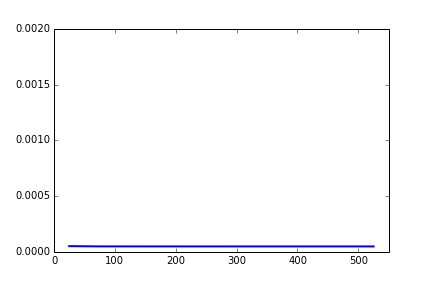
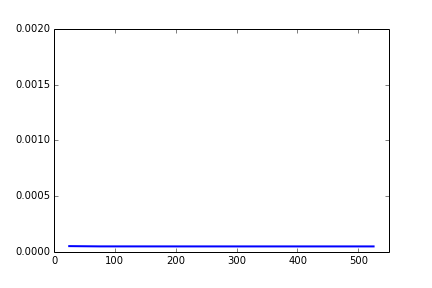
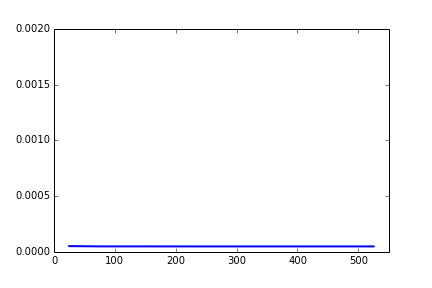
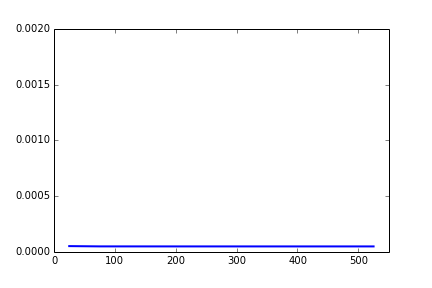
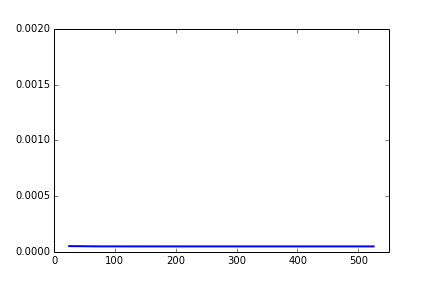
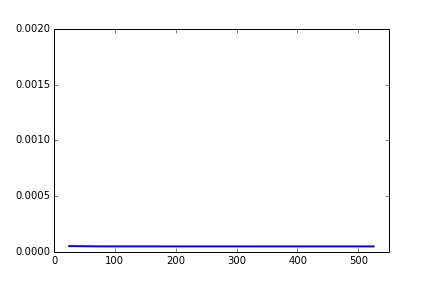
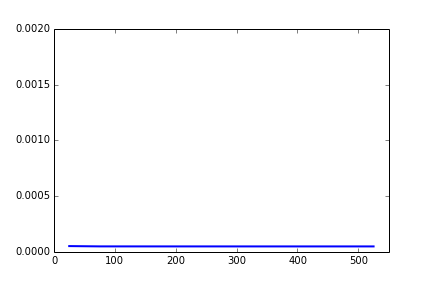
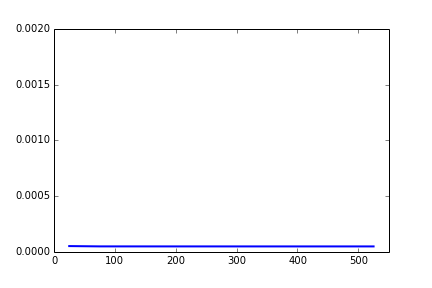
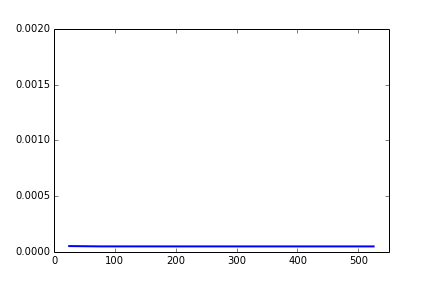
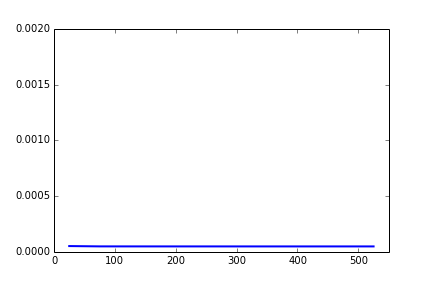
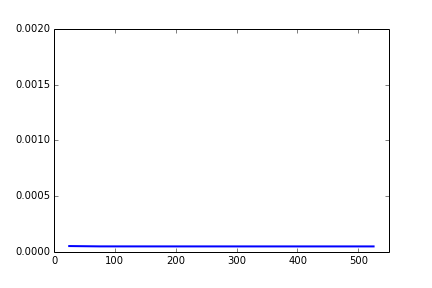
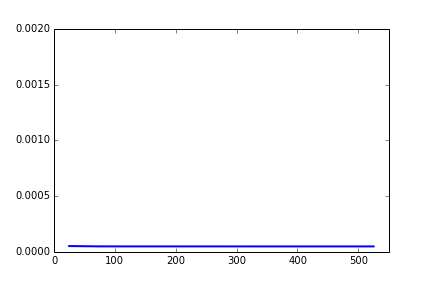
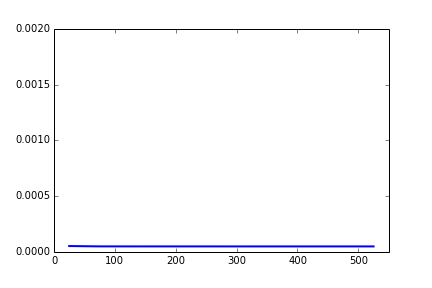
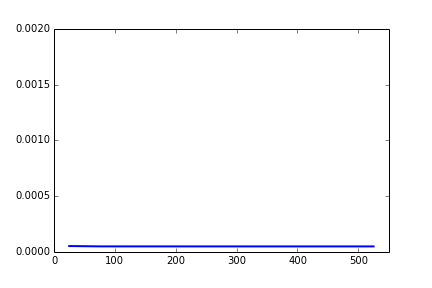
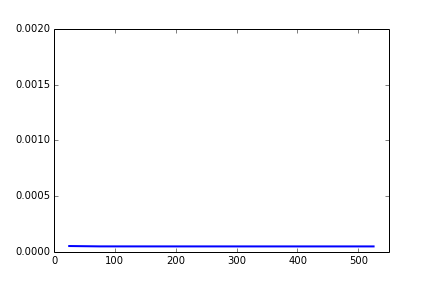
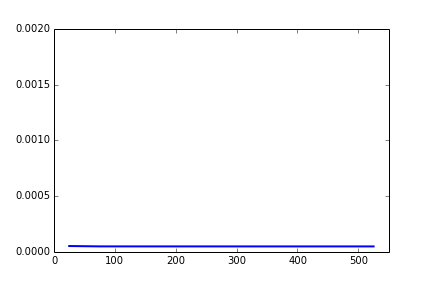
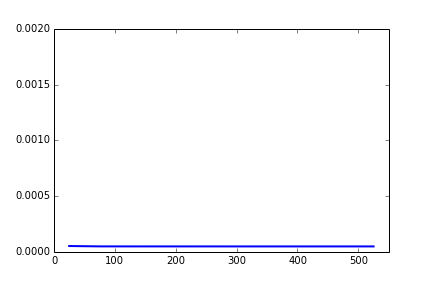
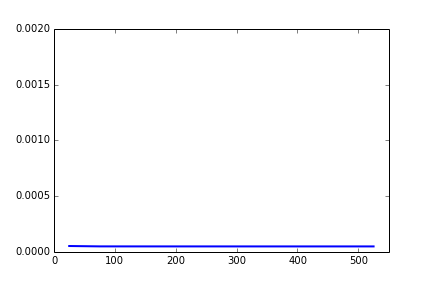
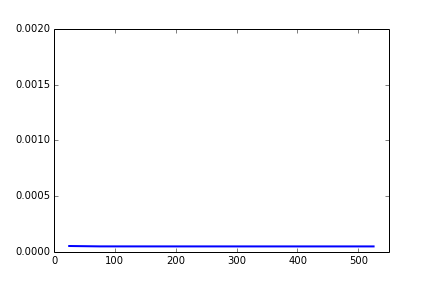
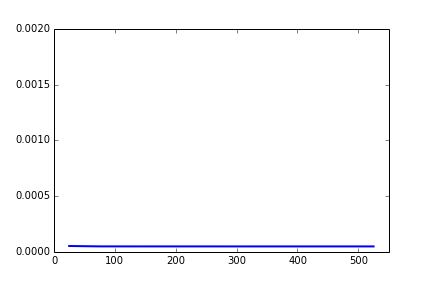
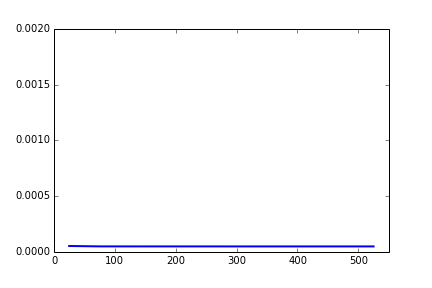
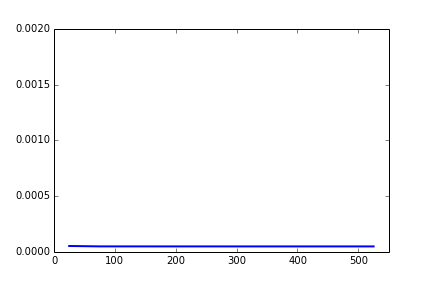
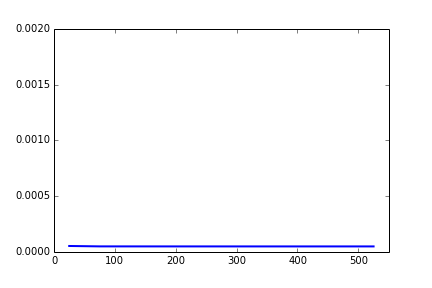
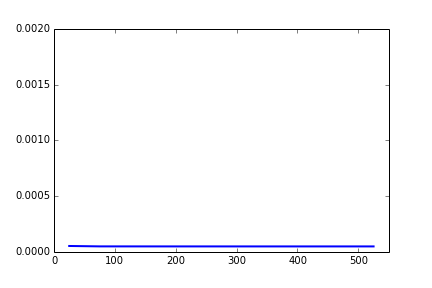
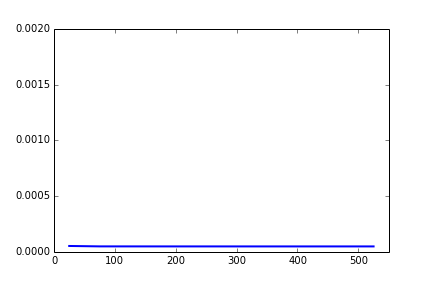
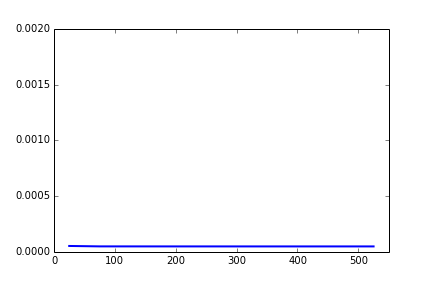
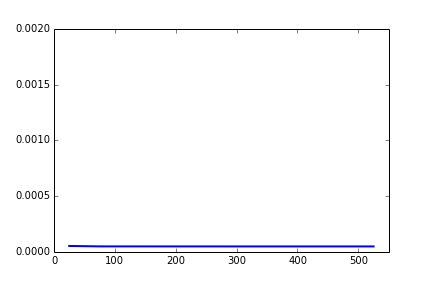
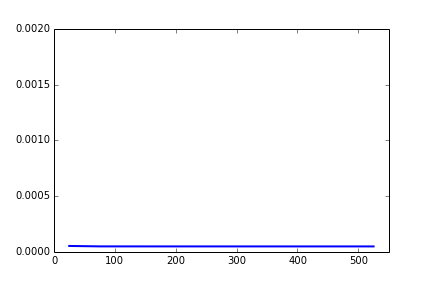
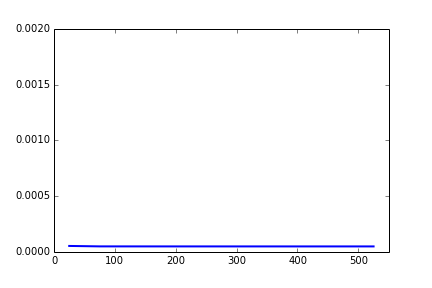
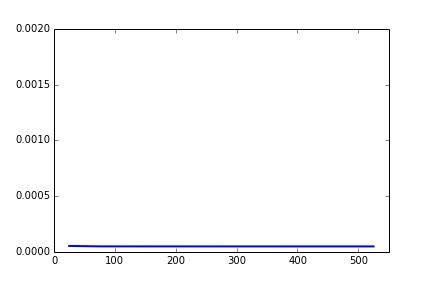
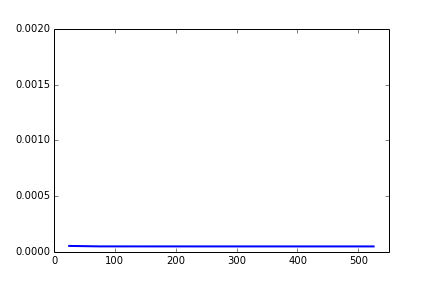
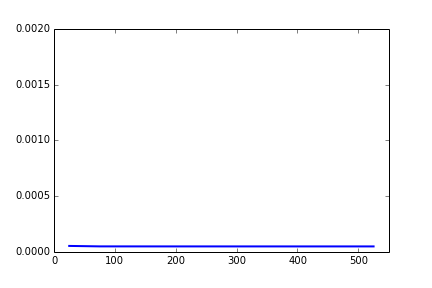
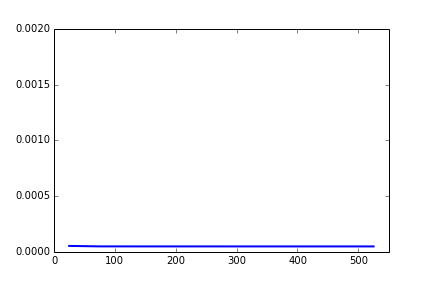
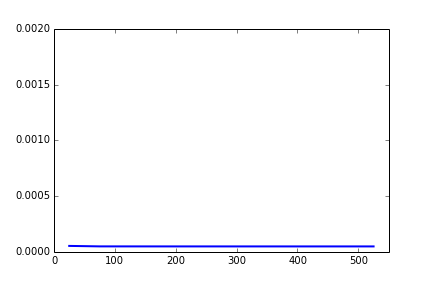
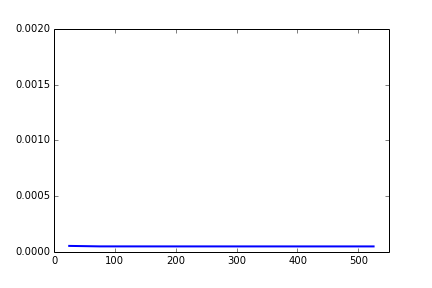
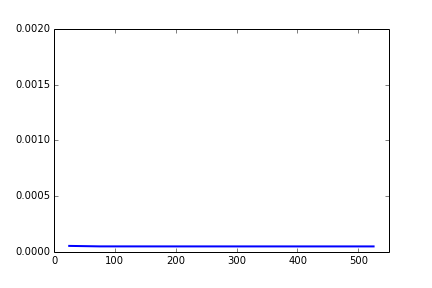
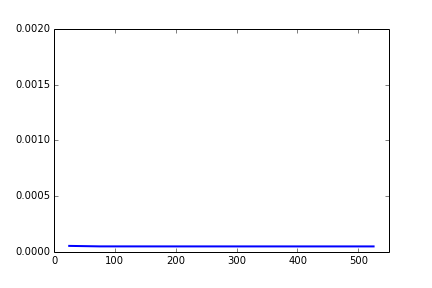
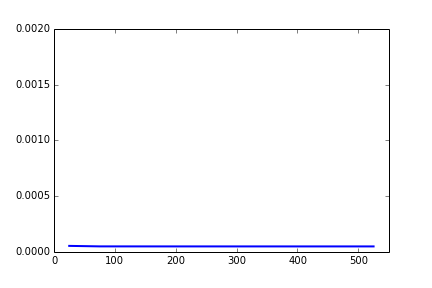
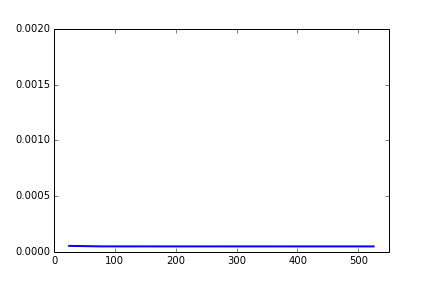
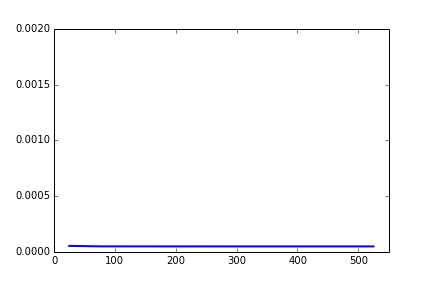
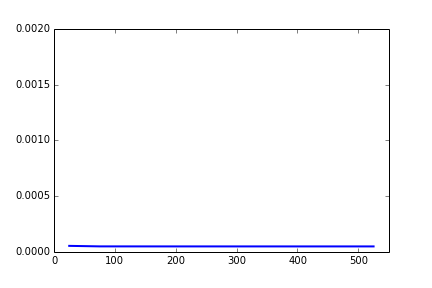
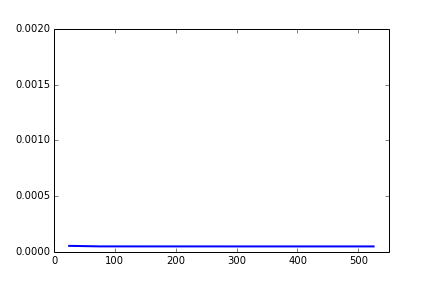
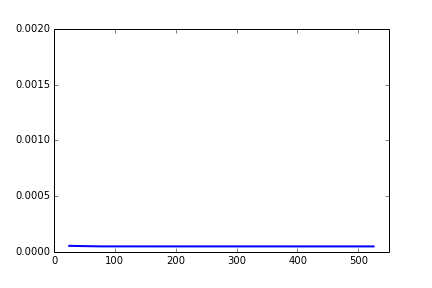
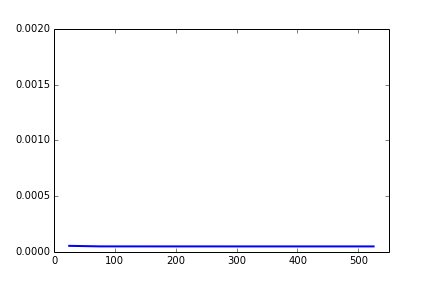
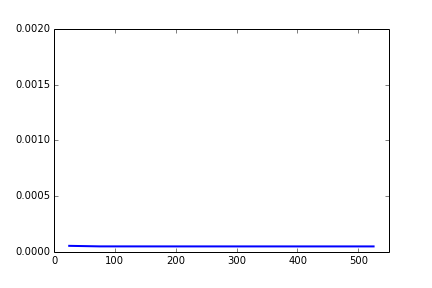

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(0, model.N*model.dx*1e6), ylim=(0,2e-3))
line, = ax.plot([], [], lw=2)
ttl = ax.text(120, .025, '')

dt = 200
frames = len(system_states)/dt

def init():
    line.set_data([], [])
    ttl.set_text('t='+str(0.0))
    return line,

def animate(i):
    line.set_data(model.x*1e6,1e3*neuron.value(Ca,system_states[i*dt]))
    ttl.set_text('t='+str(t[i*dt]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=frames, interval=100, blit=True)

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(0, model.N*model.dx*1e6), ylim=(0,2e-3))
line, = ax.plot([], [], lw=2)
ttl = ax.text(120, .025, '')

dt = 200
frames = len(system_states)/dt

def init():
    line.set_data([], [])
    ttl.set_text('t='+str(0.0))
    return line,

def animate(i):
    line.set_data(model.x*1e6,1e3*glia.value(Ca,system_states[i*dt]))
    ttl.set_text('t='+str(t[i*dt]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=frames, interval=100, blit=True)

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(0, model.N*model.dx*1e6), ylim=(-75,30))
line, = ax.plot([], [], lw=2)
tt0 = ax.text(120,20, 'V_n (mV)')
ttl = ax.text(120, .025, '')

dt = 50
frames = len(system_states)/dt

def init():
    line.set_data([], [])
    ttl.set_text('t='+str(0.0))
    return line,

def animate(i):
    line.set_data(model.x*1e6,1e3*neuron_mem.phi(system_states[i*dt]))
    ttl.set_text('t='+str(t[i*dt]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=frames, interval=100, blit=True)

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(0, model.N*model.dx*1e6), ylim=(-85,30))
line, = ax.plot([], [], lw=2)
tt0 = ax.text(120,20, 'V_g (mV)')
ttl = ax.text(120, .025, '')

dt = 50
frames = len(system_states)/dt

def init():
    line.set_data([], [])
    ttl.set_text('t='+str(0.0))
    return line,

def animate(i):
    line.set_data(model.x*1e6,1e3*glial_mem.phi(system_states[i*dt]))
    ttl.set_text('t='+str(t[i*dt]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=frames, interval=100, blit=True)

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(0, model.N*model.dx*1e6), ylim=(0.05,0.95))
line, = ax.plot([], [], lw=2)
tt0 = ax.text(120,0.8, 'v_ecs')
ttl = ax.text(120, .65, '')

dt = 50
frames = len(system_states)/dt

def init():
    line.set_data([], [])
    ttl.set_text('t='+str(0.0))
    return line,

def animate(i):
    vfracs = model.volumefractions(system_states[i*dt])
    line.set_data(model.x*1e6,vfracs[ecs])
    ttl.set_text('t='+str(t[i*dt]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=frames, interval=100, blit=True)

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(0, model.N*model.dx*1e6), ylim=(0.05,0.95))
line, = ax.plot([], [], lw=2)
tt0 = ax.text(120,0.8, 'v_n')
ttl = ax.text(120, .55, '')

dt = 50
frames = len(system_states)/dt

def init():
    line.set_data([], [])
    ttl.set_text('t='+str(0.0))
    return line,

def animate(i):
    vfracs = model.volumefractions(system_states[i*dt])
    line.set_data(model.x*1e6,vfracs[neuron])
    ttl.set_text('t='+str(t[i*dt]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=frames, interval=100, blit=True)

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(0, model.N*model.dx*1e6), ylim=(0.05,0.95))
line, = ax.plot([], [], lw=2)

tt0 = ax.text(120, .7, 'v_g')
ttl = ax.text(120, .55, '')

dt = 50
frames = len(system_states)/dt

def init():
    line.set_data([], [])
    ttl.set_text('t='+str(0.0))
    return line,

def animate(i):
    vfracs = model.volumefractions(system_states[i*dt])
    line.set_data(model.x*1e6,vfracs[glia])
    ttl.set_text('t='+str(t[i*dt]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=frames, interval=100, blit=True)

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(0, model.N*model.dx*1e6), ylim=(-0.05,.05))
line, = ax.plot([], [], lw=2)

tt0 = ax.text(120, .7, 'charge difference')
ttl = ax.text(120, .55, '')

dt = 50
frames = len(system_states)/dt

def init():
    line.set_data([], [])
    ttl.set_text('t='+str(0.0))
    return line,

def animate(i):
    line.set_data(model.x*1e6,ecs.charge(system_states[i*dt])-neuron.charge(system_states[i*dt]))
    ttl.set_text('t='+str(t[i*dt]))
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=frames, interval=100, blit=True)

In [ ]:
ecs.charge(system_states[-1])-neuron.charge(system_states[-1])

In [ ]:
neuron.charge(system_states[-1])

In [ ]:
neuron.value(Ca,system_states[-1])